<p style="font-size:20px;">Simulator: QiskitAer, FakeTorino, ideal device noise simulator (no shot noise). H4 (rectangular) in minimal basis (STO-3G), JW mapping, 3-layered tUPS. With 40 samples generated randomly, number of parameters is 27, number of non Clifford parameters k = 3. Fitting methods: Square regression with a linear ansatz, Nonlinear Fitting, XGB, MLP.</p>

In [1]:
import pyscf
import slowquant.SlowQuant as sq
from qiskit_nature.second_q.mappers import JordanWignerMapper
from slowquant.qiskit_interface.interface import QuantumInterface
from slowquant.qiskit_interface.wavefunction import WaveFunction
#from slowquant.qiskit_interface.linear_response.projected import quantumLR

from qiskit_ibm_runtime.fake_provider import FakeTorino

from qiskit.primitives import Estimator

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Sampler
from qiskit_aer.primitives import SamplerV2

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import random

from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

In [6]:
mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                      H 1.5 0.0 0.0;
                      H 0.0 1.8 0.0;
                      H 1.5 1.8 0.0;""", basis="sto-3g", unit="angstrom")
rhf = pyscf.scf.RHF(mol).run()

sampler = Estimator()
primitive = sampler
mapper = JordanWignerMapper()
# For H4 you can make the wavefunction better by increasing n_layers.
# n_layers: 3 will prob. give almost the FCI solution.
QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 3, "do_pp": True}, ISA = True)

WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (4, 4),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
    #include_active_kappa = True
)

#WF.run_vqe_2step("RotoSolve", maxiter=3)
#WF.run_vqe_2step("SLSQP", maxiter=40)
WF.ansatz_parameters = [3.142800380570141, 2.802123553483023, 3.141844220036336, 3.1415016877195234, 2.7699109323169533, 3.140289037489865, 1.5722892785591813, -0.05183267369041262, -3.139930460730367, -3.05193091891377, 0.07499512879186974, 0.26977250393898994, -2.875485939584386, -0.18478422435886988, 0.21835082743355141, -3.145279642647945, 0.2027868009455131, 3.141049426792193, -2.802097303067954, -0.20245039509840054, 0.14415193008627167, 0.24779481988227897, -0.04867618752527981, -3.0111535837495227, -3.1367777510378136, -0.21605050555915123, -3.14472880076259]

#no noise
nonclif_ground_state_energy = WF.energy_elec
print("Non-Clifford Ground state energy:", nonclif_ground_state_energy)

#device noise
# Update the primitive with simulated noise
backend = FakeTorino()
QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
QI.do_postselection = False
QI.do_M_mitigation = False
noise_model = NoiseModel.from_backend(backend)
sampler = Sampler(backend_options={"noise_model":noise_model})
WF.change_primitive(sampler)    
# Calculate the ground state energy using the noisy simulator
noisy_nonclif_ground_state_energy = WF.energy_elec
print("Noisy Non-Clifford Ground state energy:",noisy_nonclif_ground_state_energy)

converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3


/tmp/ipykernel_2683058/1838215017.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


Non-Clifford Ground state energy: -3.7124973705678315
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [17, 25, 35, 24, 28, 26, 27, 44]
 Non-local gates:     405
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'cz', 'id', 'x', 'sx', 'measure']>)

Noisy Non-Clifford Ground state energy: -2.935460920003001


In [5]:
print(WF.ansatz_parameters)

[3.142800380570141, 2.802123553483023, 3.141844220036336, 3.1415016877195234, 2.7699109323169533, 3.140289037489865, 1.5722892785591813, -0.05183267369041262, -3.139930460730367, -3.05193091891377, 0.07499512879186974, 0.26977250393898994, -2.875485939584386, -0.18478422435886988, 0.21835082743355141, -3.145279642647945, 0.2027868009455131, 3.141049426792193, -2.802097303067954, -0.20245039509840054, 0.14415193008627167, 0.24779481988227897, -0.04867618752527981, -3.0111535837495227, -3.1367777510378136, -0.21605050555915123, -3.14472880076259]


In [7]:
#prepare training set
clif_ground_state_energies = []
noisy_clif_ground_state_energies = []
n_replacements = 3

for n in range(40):
    QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 3, "do_pp": True}, ISA = True)

    WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (4, 4),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
    #include_active_kappa = True
    )

    indices_to_replace = random.sample(range(len(WF.ansatz_parameters)), n_replacements)
    for index in indices_to_replace:
        WF.ansatz_parameters[index] = random.uniform(0, 2*np.pi)
    print(WF.ansatz_parameters)

    clif_ground_state_energy = WF.energy_elec
    clif_ground_state_energies.append(clif_ground_state_energy)
    
    backend = FakeTorino()
    QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
    QI.do_postselection = False
    QI.do_M_mitigation = False
    noise_model = NoiseModel.from_backend(backend)
    sampler = Sampler(backend_options={"noise_model":noise_model})
    WF.change_primitive(sampler)   
    noisy_clif_ground_state_energy = WF.energy_elec
    noisy_clif_ground_state_energies.append(noisy_clif_ground_state_energy)

Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.617517393271039, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.7176668007338627, 3.6419178410011437, 0.0, 0.0, 0.0, 0.0, 0.0]
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [17, 25, 35, 24, 28, 26, 27, 44]
 Non-local gates:     405
 Transpilation strategy: External PassManager
 Primiti

In [7]:
print(clif_ground_state_energies)
print(noisy_clif_ground_state_energies)

[np.float64(-2.446406320979783), np.float64(-2.2382148403762803), np.float64(-2.90595787781072), np.float64(-2.955895932712336), np.float64(-3.239645374773196), np.float64(-2.681252828243805), np.float64(-2.955535616126593), np.float64(-3.3525615170793155), np.float64(-2.9530236973267066), np.float64(-2.901496383913557), np.float64(-2.742200763414281), np.float64(-3.3037944822846006), np.float64(-3.51648309230777), np.float64(-2.4672986957109697), np.float64(-2.766543912358648), np.float64(-2.290425130088926), np.float64(-2.815076352134565), np.float64(-3.259878710660292), np.float64(-2.9375697228359736), np.float64(-3.0503470100608507), np.float64(-2.572690346539166), np.float64(-2.680028205259519), np.float64(-2.8628196468858276), np.float64(-3.215441146416697), np.float64(-3.527095496159578), np.float64(-3.4380538208344076), np.float64(-3.294483635045655), np.float64(-3.3284884449718293), np.float64(-2.917157451842104), np.float64(-2.9953570548253077), np.float64(-2.547556905717979)

In [8]:
#data preparation
nonclif_ground_state_energies = [nonclif_ground_state_energy for _ in range(len(clif_ground_state_energies))]
noisy_nonclif_ground_state_energies = [noisy_nonclif_ground_state_energy for _ in range(len(noisy_clif_ground_state_energies))]
X = np.array(noisy_clif_ground_state_energies).reshape(-1, 1)
y = np.array(clif_ground_state_energies)
X_test = np.array(noisy_nonclif_ground_state_energies).reshape(-1, 1)
y_test = np.array(nonclif_ground_state_energies)

In [9]:
#square regression with a linear ansatz
def cost_function(a, X_exact, X_noisy):
    a1, a2 = a  # 将参数 a 拆分为 a1 和 a2
    # 计算代价函数 C 的值
    C = np.sum((X_exact - (a1 * X_noisy + a2))**2)
    return C
X_exact = np.array(clif_ground_state_energies)
X_noisy = np.array(noisy_clif_ground_state_energies)
# 初始猜测值 a1 和 a2
initial_guess = [1, 0]
# 最小化代价函数
result = minimize(cost_function, initial_guess, args=(X_exact, X_noisy))
# 得到最优的 a1 和 a2
a1_optimal, a2_optimal = result.x
#print(f"最优的 a1 值: {a1_optimal}")
#print(f"最优的 a2 值: {a2_optimal}")
y_pred_linear = a1_optimal*noisy_nonclif_ground_state_energy + a2_optimal
print('result of square regression:', y_pred_linear)

result of square regression: -3.2527384632000915


In [10]:
#Nonlinear Fitting
# 定义非线性拟合函数
def nonlinear_model(X_noisy, a1, a2, a3):
    return a1 * X_noisy**2 + a2 * X_noisy + a3

# 输入数据
X_exact = np.array(clif_ground_state_energies)
X_noisy = np.array(noisy_clif_ground_state_energies)

# 使用 curve_fit 进行非线性拟合
# 初始猜测值 [a1, a2, a3]
initial_guess = [1, 1, 0]
params, covariance = curve_fit(nonlinear_model, X_noisy, X_exact, p0=initial_guess)

# 提取拟合参数
a1_optimal, a2_optimal, a3_optimal = params
#print(f"最优的 a1 值: {a1_optimal}")
#print(f"最优的 a2 值: {a2_optimal}")
#print(f"最优的 a3 值: {a3_optimal}")

# 对新的数据进行预测
y_pred_nonlinear = nonlinear_model(noisy_nonclif_ground_state_energy, a1_optimal, a2_optimal, a3_optimal)
print('Result of Nonlinear Fitting:', y_pred_nonlinear)

Result of Nonlinear Fitting: -3.2470068368985068


In [11]:
#XGBoost
xgb_model = XGBRegressor(max_depth=20, eta=0.0005, subsample=0.7, colsample_bytree=0.7, objective='reg:absoluteerror', n_estimators=1000, random_state=42)
xgb_model.fit(X, y)
y_pred_xgb = xgb_model.predict(X_test)
# 计算均方误差
#mse_corrected_XGB = mean_squared_error(y_test, y_pred_xgb)
#print('mse:', mse_corrected_XGB)
print('result of xgb:', y_pred_xgb[0])

result of xgb: -3.1360514


In [12]:
#MLP
# 归一化数据
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# 训练MLP模型
mlp_model = MLPRegressor(hidden_layer_sizes=(120, 60), activation='relu', solver='adam', max_iter=2000, alpha=0.001, random_state=42)
mlp_model.fit(X_scaled, y)
X_test_scaled = scaler.transform(X_test)
y_pred_mlp = mlp_model.predict(X_test_scaled)
#mse_corrected_MLP = mean_squared_error(y_test, y_pred_mlp)
#print('mse:', mse_corrected_MLP)
print('result of mlp:', y_pred_mlp[0])

result of mlp: -3.351144930947484


In [13]:
delta_linear = nonclif_ground_state_energy - y_pred_linear
delta_nonlinear = nonclif_ground_state_energy - y_pred_nonlinear
delta_xgb = nonclif_ground_state_energy - y_pred_xgb[0]
delta_mlp = nonclif_ground_state_energy - y_pred_mlp[0]
print(delta_linear)
print(delta_nonlinear)
print(delta_xgb)
print(delta_mlp)

-0.45975890736773994
-0.4654905336693247
-0.5764459541707367
-0.36135243962034735


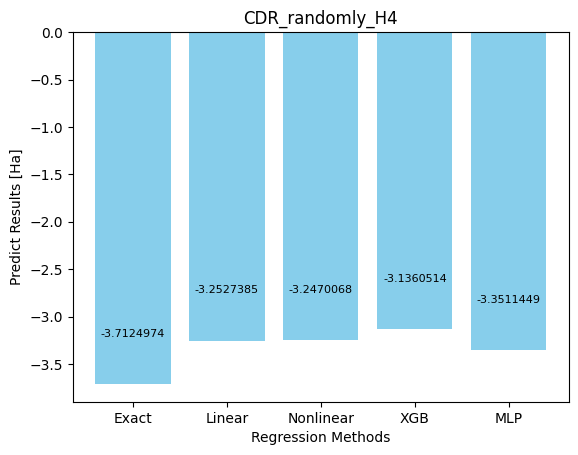

In [14]:
# 数据
categories = ['Exact', 'Linear', 'Nonlinear', 'XGB', 'MLP']
values = [nonclif_ground_state_energy, y_pred_linear, y_pred_nonlinear, y_pred_xgb[0], y_pred_mlp[0]]

# 绘制柱状图
plt.bar(categories, values, color='skyblue')

# 添加标题和标签
plt.title('CDR_randomly_H4')
plt.xlabel('Regression Methods')
plt.ylabel('Predict Results [Ha]')

# 在每个柱子上标注数值
for i, v in enumerate(values):
    plt.text(i, v + 0.5, f"{v:.7f}", ha='center', fontsize=8)

# 显示图表
plt.show()